In [110]:
import os, json, cv2, random
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import math

from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode

from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler

from rasterio.transform import from_bounds

In [22]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # small for now, probably should be 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = "../Treework/detectron_output/"
cfg.MODEL.DEVICE='cpu'
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0054999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

In [3]:
class Skysat(RasterDataset):
    filename_glob = "*.tif"
    filename_regex = r"()"
    date_format = "%Y%m%d"
    is_image = True
    separate_files = True
    all_bands = ["red", "green", "blue"]
    rgb_bands = ["red", "green", "blue"]
    
    def __getitem__(self, index):
        sample_dict = super().__getitem__(index)

        # Convert image to tensor here, so that we can handle the bands
        # Compute the affine transform for this image
        image = sample_dict['image']

        transform = self.get_transform(sample_dict["bounds"], image.shape[1], image.shape[2])
        sample_dict["transform"] = transform
        return sample_dict

    def get_transform(self, bounds, height, width):
        # Convert a BoundingBox in pixel coordinates to an affine transform
        left, top, right, bottom = bounds.minx, bounds.maxy, bounds.maxx, bounds.miny
        return from_bounds(left, bottom, right, top, width, height)
    
    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0).numpy().astype(int)

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

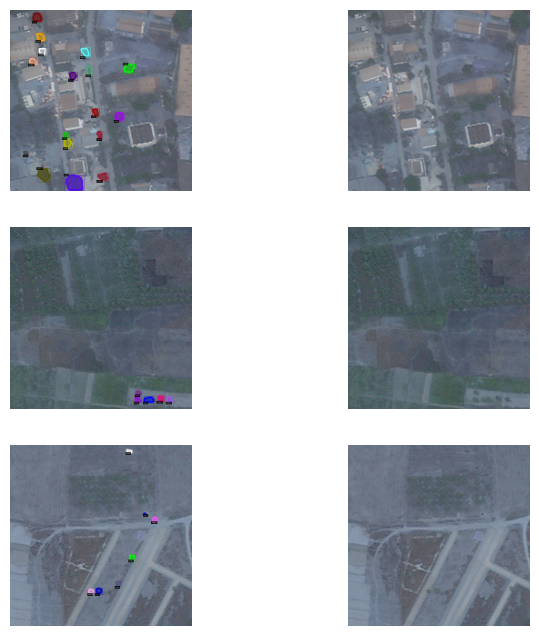

In [23]:
from PIL import Image
import torch
import random
import string
import rasterio

torch.manual_seed(3)

dataset = Skysat('./NUTMGS/tifs_for_labeling/karnataka_top_10_tifs/')

sampler = GridGeoSampler(dataset, size=400, stride=400)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 3
printed = 0

for i, batch in enumerate(dataloader):
    if printed == rows:
        break

    if random.random() > 0.01:
        continue
    
    unbinded = unbind_samples(batch)
    sample = unbinded[0]

    im = sample['image'][0:3].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("test"), 
                   scale=0.5, 
                   font_size_scale=0
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    figure.add_subplot(rows, cols, 2*printed+1)
    plt.axis("off")
    plt.imshow(out.get_image())
    
    figure.add_subplot(rows, cols, 2*printed+2)
    plt.axis("off")
    plt.imshow(im[:, :, ::-1])

    printed += 1

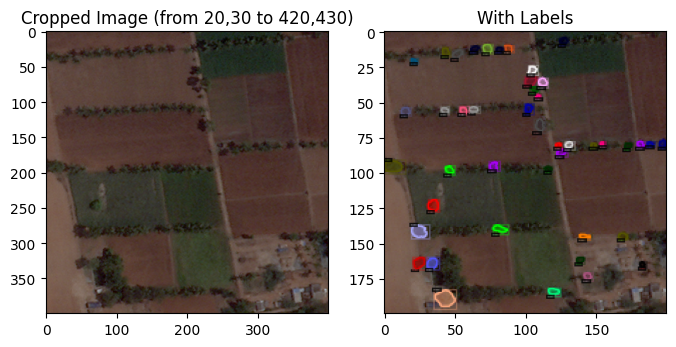

In [59]:
test_tif = './NUTMGS/filtered_tifs_for_labeling/1a9844d3-75dd-40e8-9a3c-efe903a48a51/SkySatScene/20220424_045952_ssc13d3_0016_visual.tif'
tif = rasterio.open(test_tif)

# Crop data
col_offset = 20
row_offset = 30
crop_width = 400
crop_height = 400
window = rasterio.windows.Window(col_offset, row_offset, crop_width, crop_height)

# Read the cropped data
cropped_image = tif.read([1,2,3], window=window).transpose((1,2,0)).astype(np.uint8) # Read band 1

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 1

# Display the cropped image
figure.add_subplot(rows, cols, 1)
plt.imshow(cropped_image)
plt.title(f"Cropped Image (from {col_offset},{row_offset} to {col_offset+crop_width},{row_offset+crop_height})")

outputs = predictor(cropped_image)
v = Visualizer(cropped_image,
                metadata=MetadataCatalog.get("test"), 
                scale=0.5, 
                font_size_scale=0
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

figure.add_subplot(rows, cols, 2)
plt.imshow(out.get_image())
plt.title(f"With Labels")

plt.show()

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4635, 'height': 1916, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'), 'transform': Affine(0.5, 0.0, 678577.0,
       0.0, -0.5, 1609640.5), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}
[<POLYGON ((678690.25 1609593.25, 678689.75 1609592.75, 678688.75 1609592.75,...>, <POLYGON ((678621.75 1609505.75, 

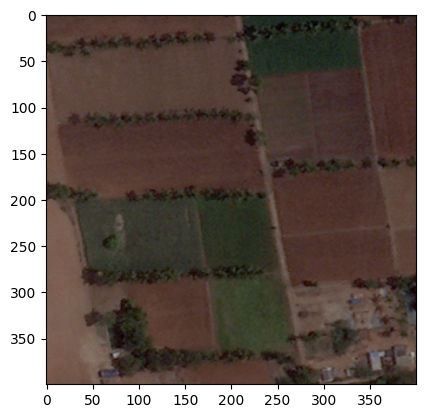

In [94]:
from shapely.geometry import Polygon, MultiPolygon

test_tif = './NUTMGS/filtered_tifs_for_labeling/1a9844d3-75dd-40e8-9a3c-efe903a48a51/SkySatScene/20220424_045952_ssc13d3_0016_visual.tif'
tif = rasterio.open(test_tif)
print(tif.profile)

# Crop data
col_offset = 20
row_offset = 30
crop_width = 400
crop_height = 400
window = rasterio.windows.Window(col_offset, row_offset, crop_width, crop_height)

# Read the cropped data
cropped_image = tif.read([1,2,3], window=window).transpose((1,2,0)).astype(np.uint8) # Read band 1
plt.imshow(cropped_image)

outputs = predictor(cropped_image)
polys = []
for i in range(len(outputs['instances'])):
    if outputs['instances'].has("pred_masks"):
        mask = outputs['instances'].pred_masks[i].numpy().astype(np.uint8)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if contour.size >= 6:
                xs = [c[0][1]+row_offset for c in contour]
                ys = [c[0][0]+col_offset for c in contour]
                xs, ys = rasterio.transform.xy(tif.transform, xs, ys)
                poly = Polygon([(xs[i], ys[i]) for i in range(len(xs))])
                polys.append(poly)

v = Visualizer(cropped_image,
                metadata=MetadataCatalog.get("test"), 
                scale=0.5, 
                font_size_scale=0
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# plt.imshow(out.get_image())

print(polys)
gdf = gpd.GeoDataFrame({'name': ['test_shape'], 'geometry': [MultiPolygon(polys)]}, crs=tif.crs) \
    .to_crs(4326) # convert to EE format
print(gdf)

gdf.to_file('create_shapes/test.shp')

In [140]:
def get_jump_amount(tif):
    num_w = math.ceil(tif.profile['width'] * 1.12 / 400 - 0.2)
    num_h = math.ceil(tif.profile['height'] * 1.12 / 400 - 0.2)

    extra_w = num_w * 400 - tif.profile['width']
    extra_h = num_h * 400 - tif.profile['height']

    w_gap_size = extra_w / max(num_w - 1, 1)
    h_gap_size = extra_h / max(num_h - 1, 1)

    return num_w, num_h, 400 - w_gap_size, 400 - h_gap_size

In [132]:
from collections import defaultdict

def transform_contours_to_xy(contours, transform):
    tp = []
    for cnt in contours:
        pl = cnt[:, 0, :]
        cols, rows = zip(*pl)
        x,y = rasterio.transform.xy(transform, rows, cols)
        tl = [list(i) for i in zip(x, y)]
        tp.append(tl)
    return (tp)

def mask_to_polygons(mask, transform, th = 0.5):
    # first, find contours with cv2: it's much faster than shapely and returns hierarchy
    mask[mask < th] = 0
    mask[mask >= th] = 1
    mask = ((mask) * 255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    #Convert contours from image coordinate to xy coordinate (world coordinates)
    contours = transform_contours_to_xy(contours, transform)

    if not contours: #TODO: Raise an error maybe
        print('Warning: No contours/polygons detected!!')
        return [Polygon()]#[Polygon()]
    
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])
    # create actual polygons filtering by area/hole (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(contours):
        if idx not in child_contours: #and cv2.contourArea(cnt) >= min_area: #Do we need to check for min_area??
            try:
                poly = Polygon(
                    shell=cnt,
                    holes=[c for c in cnt_children.get(idx, [])])
                           #if cv2.contourArea(c) >= min_area]) #Do we need to check for min_area??
                all_polygons.append(poly)
            except Exception as e: 
#                 print(e)
                pass
#     print(len(all_polygons))
    return(all_polygons)

In [191]:
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

def create_multipolygon_from_tif(tif_name):
    tif = rasterio.open(tif_name)
    num_w, num_h, dw, dh = get_jump_amount(tif)

    all_polys = MultiPolygon([])
    for r_grid in range(num_h):
        for c_grid in range(num_w):

            # Crop data
            col_offset = round(dw * c_grid)
            row_offset = round(dh * r_grid)
            crop_width = 400
            crop_height = 400
            window = rasterio.windows.Window(col_offset, row_offset, crop_width, crop_height)

            # Read the cropped data
            cropped_image = tif.read([1,2,3], window=window).transpose((1,2,0)).astype(np.uint8) # Read band 1

            polys = []
            outputs = predictor(cropped_image)
            for i in range(len(outputs['instances'])):
                if outputs['instances'].has("pred_masks"):
                    mask = outputs['instances'].pred_masks[i].numpy().astype(np.uint8)
                    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                    for contour in contours:
                        if contour.size >= 6:
                            xs = [c[0][1]+row_offset for c in contour]
                            ys = [c[0][0]+col_offset for c in contour]
                            xs, ys = rasterio.transform.xy(tif.transform, xs, ys)
                            poly = Polygon([(xs[i], ys[i]) for i in range(len(xs))])
                            polys.append(poly.buffer(0))

            if (len(polys) > 0):
                if str(type(all_polys)) == "<class 'shapely.geometry.multipolygon.MultiPolygon'>":
                    l = list(all_polys.geoms)
                    l.extend(polys)
                    all_polys = unary_union(l)
                elif str(type(all_polys)) == "<class 'shapely.geometry.polygon.Polygon'>":
                    l = [all_polys]
                    l.extend(polys)
                    all_polys = unary_union(l)
                else:
                    all_polys = MultiPolygon(polys)

    print(all_polys)
    return all_polys

In [ ]:
test_tif = './NUTMGS/filtered_tifs_for_labeling/1a9844d3-75dd-40e8-9a3c-efe903a48a51/SkySatScene/20220424_045952_ssc13d3_0016_visual.tif'

all_polys = []
all_polys.extend(list(create_multipolygon_from_tif(test_tif).geoms))
all_polys = unary_union(all_polys)

gdf = gpd.GeoDataFrame({'name': ['trees'], 'geometry': [unary_union(all_polys)]}, crs=tif.crs) \
                .to_crs(4326) # convert to EE format
gdf.to_file('create_shapes/test_union.shp')

In [194]:
all_polys = MultiPolygon([])
for idx, dir in enumerate(os.listdir('./NUTMGS/filtered_tifs_for_labeling')):
    if dir == '.DS_Store':
        continue

    if idx >= 10:
        break

    root = f'./NUTMGS/filtered_tifs_for_labeling/{dir}/SkySatScene'
    file = [f for f in os.listdir(root) if f.count('.tif')][0]

    print(f'{root}/{file}')
    l = list(all_polys.geoms)
    l.extend(list(create_multipolygon_from_tif(f'{root}/{file}').geoms))
    all_polys = unary_union(l)

gdf = gpd.GeoDataFrame({'name': ['trees'], 'geometry': [unary_union(all_polys)]}, crs=tif.crs) \
                .to_crs(4326) # convert to EE format
gdf.to_file('create_shapes/karnataka_top_10.shp')

./NUTMGS/filtered_tifs_for_labeling/725205fa-4942-482e-95a9-0d4ee6ad2a2f/SkySatScene/20220331_082205_ssc6d1_0035_visual.tif
MULTIPOLYGON (((673297.25 1705505.25, 673297.25 1705504.25, 673296.75 1705503.75, 673295.25 1705503.75, 673295.25 1705505.75, 673296.75 1705505.75, 673297.25 1705505.25)), ((673397.75 1705522.25, 673398.25 1705521.75, 673398.25 1705520.75, 673400.75 1705518.25, 673400.75 1705517.75, 673401.25 1705517.25, 673401.25 1705516.75, 673401.75 1705516.25, 673401.75 1705514.25, 673401.25 1705513.75, 673401.25 1705512.25, 673400.75 1705511.75, 673400.75 1705509.75, 673400.25 1705509.25, 673400.25 1705508.75, 673399.75 1705508.25, 673399.25 1705508.25, 673398.75 1705507.75, 673397.75 1705507.75, 673397.25 1705508.25, 673395.75 1705508.25, 673395.25 1705508.75, 673394.25 1705508.75, 673393.75 1705509.25, 673393.25 1705509.25, 673392.25 1705510.25, 673392.25 1705510.75, 673391.25 1705511.75, 673391.25 1705512.75, 673390.75 1705513.25, 673390.75 1705513.75, 673391.25 1705514.25